# Фильтрация изображений

In [1]:
from skimage.io import imread, imshow, imsave
from skimage import img_as_uint, img_as_ubyte, img_as_float
from numpy import histogram, clip, average
import numpy as np

In [2]:
import matplotlib.pyplot as plt
def compare_img(img1, img2, label1 = '', label2 = ''):
    fig = plt.figure(figsize=(10, 10))
    
    fig.add_subplot(1, 2, 1)
    imshow(img1)
    plt.axis('off')
    plt.title(label1)
    
    fig.add_subplot(1, 2, 2)
    imshow(img2)
    plt.axis('off')
    plt.title(label2)
    
    plt.show()

def show_img(img, label = ''):
    imshow(img)
    plt.axis('off')
    plt.title(label)
    
def save_img(img, filename):
    imsave(filename, img)

In [24]:
import time

def get_curent_time():
    return time.time()

def print_execution_time(start,end):
    return print(f'Finished in {end - start:.2f}sec')

In [5]:
tigerGraySmall = imread('tiger-gray-small.png')
# ORIGINAL URL: https://stepik.org/media/attachments/lesson/61037/tiger-gray-small.png

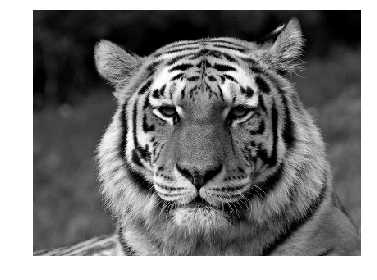

In [5]:
show_img(tigerGraySmall)

## Операция свертки 

In [9]:
from scipy.signal import convolve2d

Выполните свертку изображения

\begin{bmatrix} 0 & -8 & -3 & -2\\ 1 & 9 & -8 & 0\\ 9 & -4 & 5 & -9\\ 6 & -4 & 6 & 3 \end{bmatrix}

с ядром:

\begin{bmatrix} 4 & -5 & 4 \\ -6 & -8 & -2\\ 1 & 5 & 5 \end{bmatrix} 

Результат выпишите построчно через пробел.

In [7]:
X = [[0, -8, -3, -2], [1, 9, -8, 0], [9, -4, 5, -9], [6, -4, 6, 3]]
Y = [[4, -5, 4], [-6, -8, 2], [1, 5, 5]]

## Box-фильтр

In [3]:
from skimage.transform import integral_image, integrate
import time

def convolve(X, kernel):
    return convolve2d(X, kernel, mode='valid')

def box_filter(img, filterSize):
    start = time.time()
    img = imread('tiger-gray-small.png') 
    img = integral_image(img)*filterSize
    n = img.shape[0]-filterSize
    m = img.shape[1]-filterSize
    img_box = np.zeros([n,m],np.uint32) 
    print("Loading...")
    for i in range(n): 
        for j in range(m): 
            img_box[i,j]=integrate(img,(i,j),(i+filterSize,j+filterSize)) 
    img_box=np.uint8(img_box//100)
    end = time.time()
    print(f'Fin in {end - start}')
    return img_box

In [10]:
convolve(X, Y)

array([[ 11, -52],
       [130, -23]])

In [11]:
boxFilteredImg = box_filter(tigerGraySmall, 4)

Loading...
Fin in 21.804385900497437


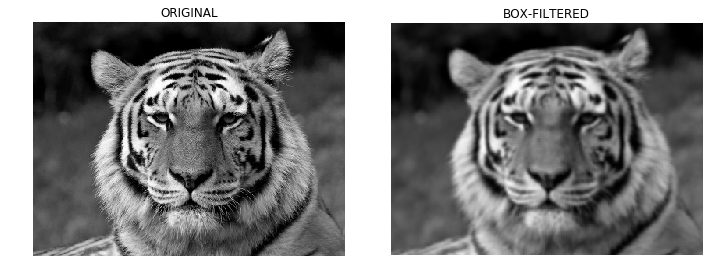

In [12]:
compare_img(tigerGraySmall, boxFilteredImg, 'ORIGINAL', 'BOX-FILTERED')

## Гауссовский фильтр

In [13]:
from math import exp, pi
def calculate_gaus(A):
    s, x, y = A
    d = 1/(2*pi*s**2)*exp((-x**2-y**2)/(2*s**2))
    return d

In [14]:
calculate_gaus([1,1,1])

0.05854983152431917

In [15]:
def show_gaus_kernel_elements(sigma):
    k = round(6 * sigma + 1)
    n = k//2
    a = np.zeros((k,k))
    d = 0
    for i in range(-n, n+1):
        for j in range(-n, n+1):
            a[i+n, j+n]=calculate_gaus([sigma,i,j])
    d = 1/sum(sum(a))
    an = a*d 
    for i in an:
        for j in i:
            print(round(j,5), end=' ')

In [16]:
show_gaus_kernel_elements(0.33)

0.0001 0.00974 0.0001 0.00974 0.96065 0.00974 0.0001 0.00974 0.0001 

In [27]:
def gaus_blur(img_origin, s, kernel=[]):
    img = img_origin.copy()
    d = 0
    k = round(s * 3 * 2 + 1)
    n= k//2
    a = np.zeros((k,k))
    for i in range(-n, n+1):
        for j in range(-n, n+1):
            a[i+n, j+n]=calculate_gaus([s,i,j])
    d = 1/sum(sum(a))
    an = (a*d)
    an = np.around(an, decimals=5)
    
    arrayList=[]
    for y in range(5):
        temparray = np.copy(img)
        temparray = np.roll(temparray, y-1, axis=0)
        for x in range(5):
            temparray_X = np.copy(temparray)
            temparray_X = np.roll(temparray_X, x-1, axis=1)*an[y,x]
            arrayList.append(temparray_X)
            
    arrayList=  np.array(arrayList)
    arrayList_sum = np.sum(arrayList, axis=0)
    
    itog = arrayList_sum
    img = clip(itog, 0, 255)
    return img.astype('uint8')

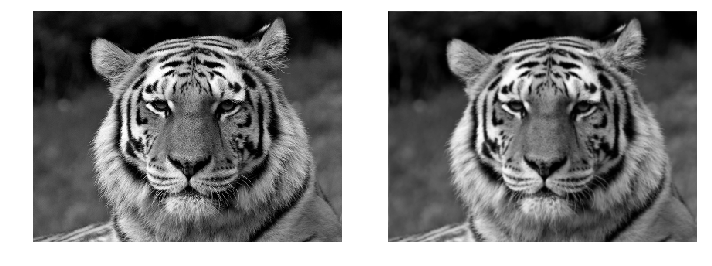

In [30]:
compare_img( tigerGraySmall, gaus_blur(tigerGraySmall, 0.66))

## Повышение резкости изображения

In [17]:
def sharpening(img):
    time_start = get_curent_time()
    res = np.array([[[0] * img.shape[1]] * img.shape[0]], dtype='float')[0]

    kernel = np.array([[-1, -2, -1],
                       [-2, 22, -2],
                       [-1, -2, -1]]) / 10

    for i in range(3, img.shape[0] + 1):
        for j in range(3, img.shape[1] + 1):
            res[i - 3, j - 3] = (img[i-3: i, j-3: j] * kernel).sum()


    res = np.clip(res[: - 2, : - 2], 0, 255).astype('uint8')
    print_execution_time(time_start, get_curent_time())
    return res

Finished in 0.72sec


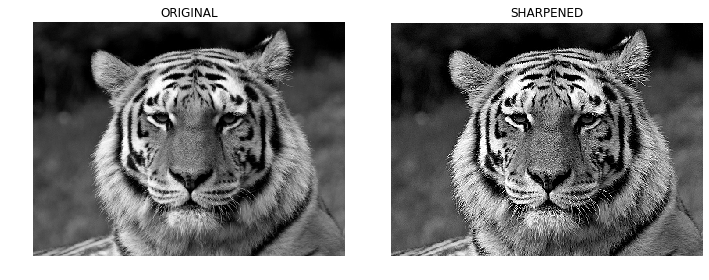

In [25]:
compare_img(tigerGraySmall, sharpening(tigerGraySmall), 'ORIGINAL', 'SHARPENED')

## Медианный фильтр

In [30]:
def custom_median_filter(img, size):
    time_start = get_curent_time()
    res = img.copy()
    rows,cols = img.shape
    half = size//2

    for i in range(half,rows-half):
        for j in range(half,cols-half):
            a = img[i-half:i+half+1,j-half:j+half+1]
            m = np.median(a)
            res[i][j] = m

    res = res[half:rows-half,half:cols-half]
    print_execution_time(time_start, get_curent_time())
    return res

Finished in 2.58sec


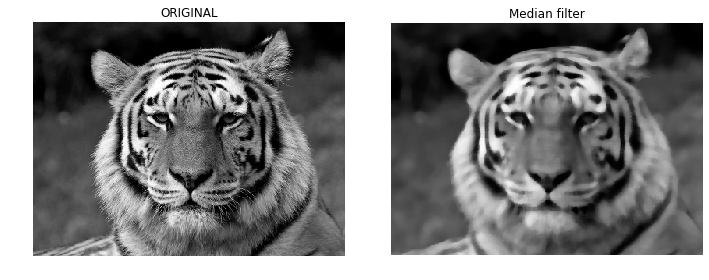

In [31]:
compare_img(tigerGraySmall, custom_median_filter(tigerGraySmall, 7), 'ORIGINAL', 'Median filter')

***

С уважением, студент гр. РИМ-181226

Кабанов Е.А.